# Modelling

In [117]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
import random
import re
from scipy.stats import kstest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score,roc_curve
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from scipy.stats import chi2_contingency
from scipy.stats import kstest
from scipy.stats import chisquare
from mixed_naive_bayes import MixedNB
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB

In [2]:
random.seed(1111)

In [3]:
train=pd.read_csv('C:/Users/wpekt/Desktop/과제/P-SAT/방세/train.csv')
test=pd.read_csv('C:/Users/wpekt/Desktop/과제/P-SAT/방세/test.csv')
train_d=train.drop(['V24_cat','V26_cat'],axis=1)
test_d=test.drop(['V24_cat','V26_cat'],axis=1)

In [5]:
train_ii=pd.read_csv('C:/Users/wpekt/Desktop/과제/P-SAT/방세/train_oe_br_hr.csv')
test_ii=pd.read_csv('C:/Users/wpekt/Desktop/과제/P-SAT/방세/test_oe_br_hr.csv')

In [6]:
def homogeneity_TF(df1,df2):
    p=0
    result=pd.DataFrame()
    for i in df1.columns:
        if i in ['id','target']:
            pass
        elif re.search('_cat',i):
            ct1=pd.crosstab(df1['target'],df1[i])
            ct2=pd.crosstab(df2['target'],df2[i])
            ct=pd.concat([ct1,ct2])
            chi2, p, dof, expected = chi2_contingency(ct)
        elif re.search('_bin',i):
            ct1=pd.crosstab(df1['target'],df1[i])
            ct2=pd.crosstab(df2['target'],df2[i])
            ct=pd.concat([ct1,ct2])
            chi2, p, dof, expected = chi2_contingency(ct)
        elif train[i].nunique()>100: #고유하게 나타나는 값이 100 이상일때는 KS Test 진행
            p=kstest(df1[i],df2[i])[1]
        else: # 그 외에는 Ordinal Data라고 가정하고 카이제곱검정 진행
            ct1=pd.crosstab(df1['target'],df1[i])
            ct2=pd.crosstab(df2['target'],df2[i])
            ct=pd.concat([ct1,ct2])
            ct.fillna(0,inplace=True)
            chi2, p, dof, expected = chi2_contingency(ct)
            
        temp=pd.DataFrame.from_dict([{'Variable': i,'p_value':round(p,4)}])
        result=pd.concat([result,temp])
        
    return result

In [7]:
train_pos_d=train_d[train_d['target']==1]
train_neg_d=train_d[train_d['target']==0]

In [8]:
hr=homogeneity_TF(train_pos_d,train_neg_d)
hr_list=hr[hr['p_value']<0.05].iloc[2:]['Variable'].to_list()

In [9]:
col_cath=[]
col_numh=[]
col_binh=[]
col_ordh=[]
for i in hr_list:
    if '_cat' in i:
        col_cath.append(i)
    elif re.search('_bin',i):
        col_binh.append(i)
    elif train_d[i].nunique()>100:
        col_numh.append(i)
    else:
        col_ordh.append(i)

In [10]:
train_pos_ii=train_ii[train_ii['target']==1]
train_neg_ii=train_ii[train_ii['target']==0]

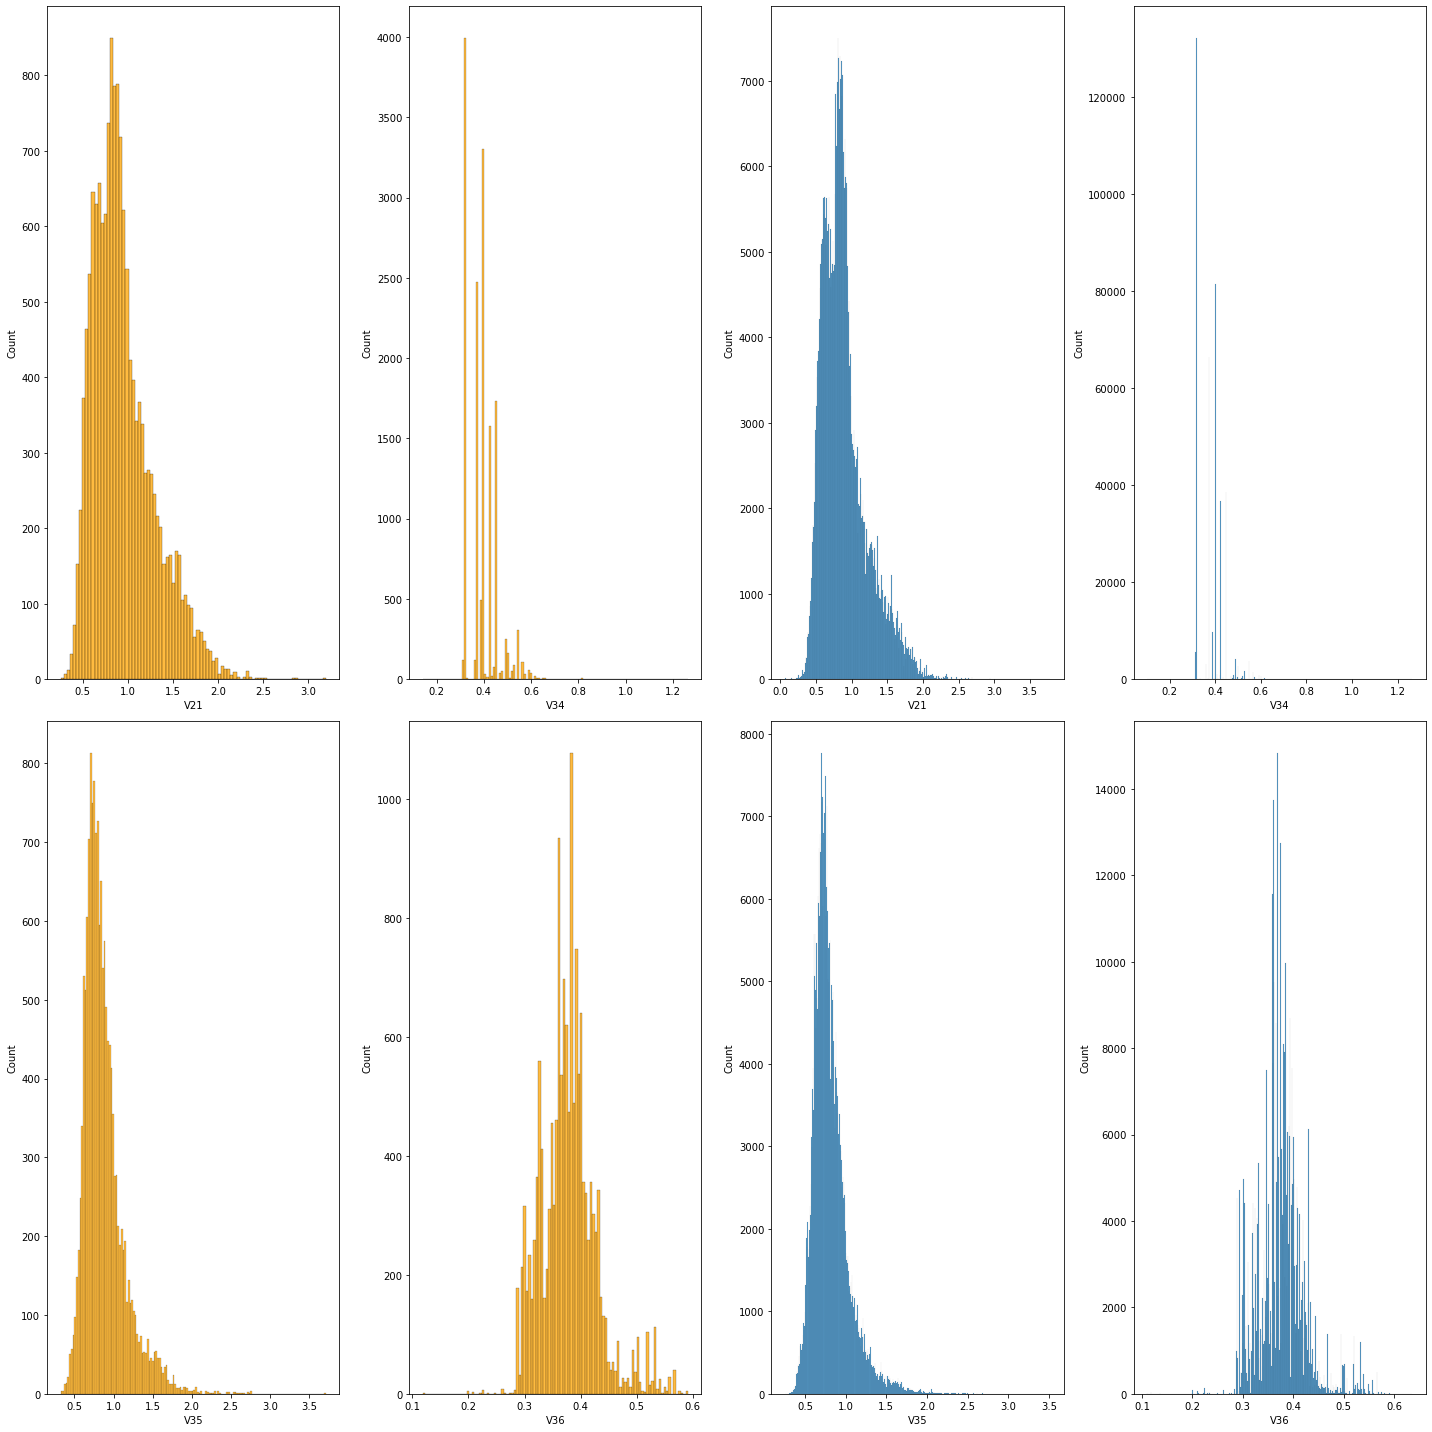

In [11]:
figure, axs = plt.subplots(nrows=(len(col_numh)//2), ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_pos_ii[col_numh]):
    sns.histplot(train_pos_ii, x=col,color='orange',ax=axs[i//2,i%2])
    sns.histplot(train_neg_ii, x=col,ax=axs[i//2,i%2+2])
figure.tight_layout() 

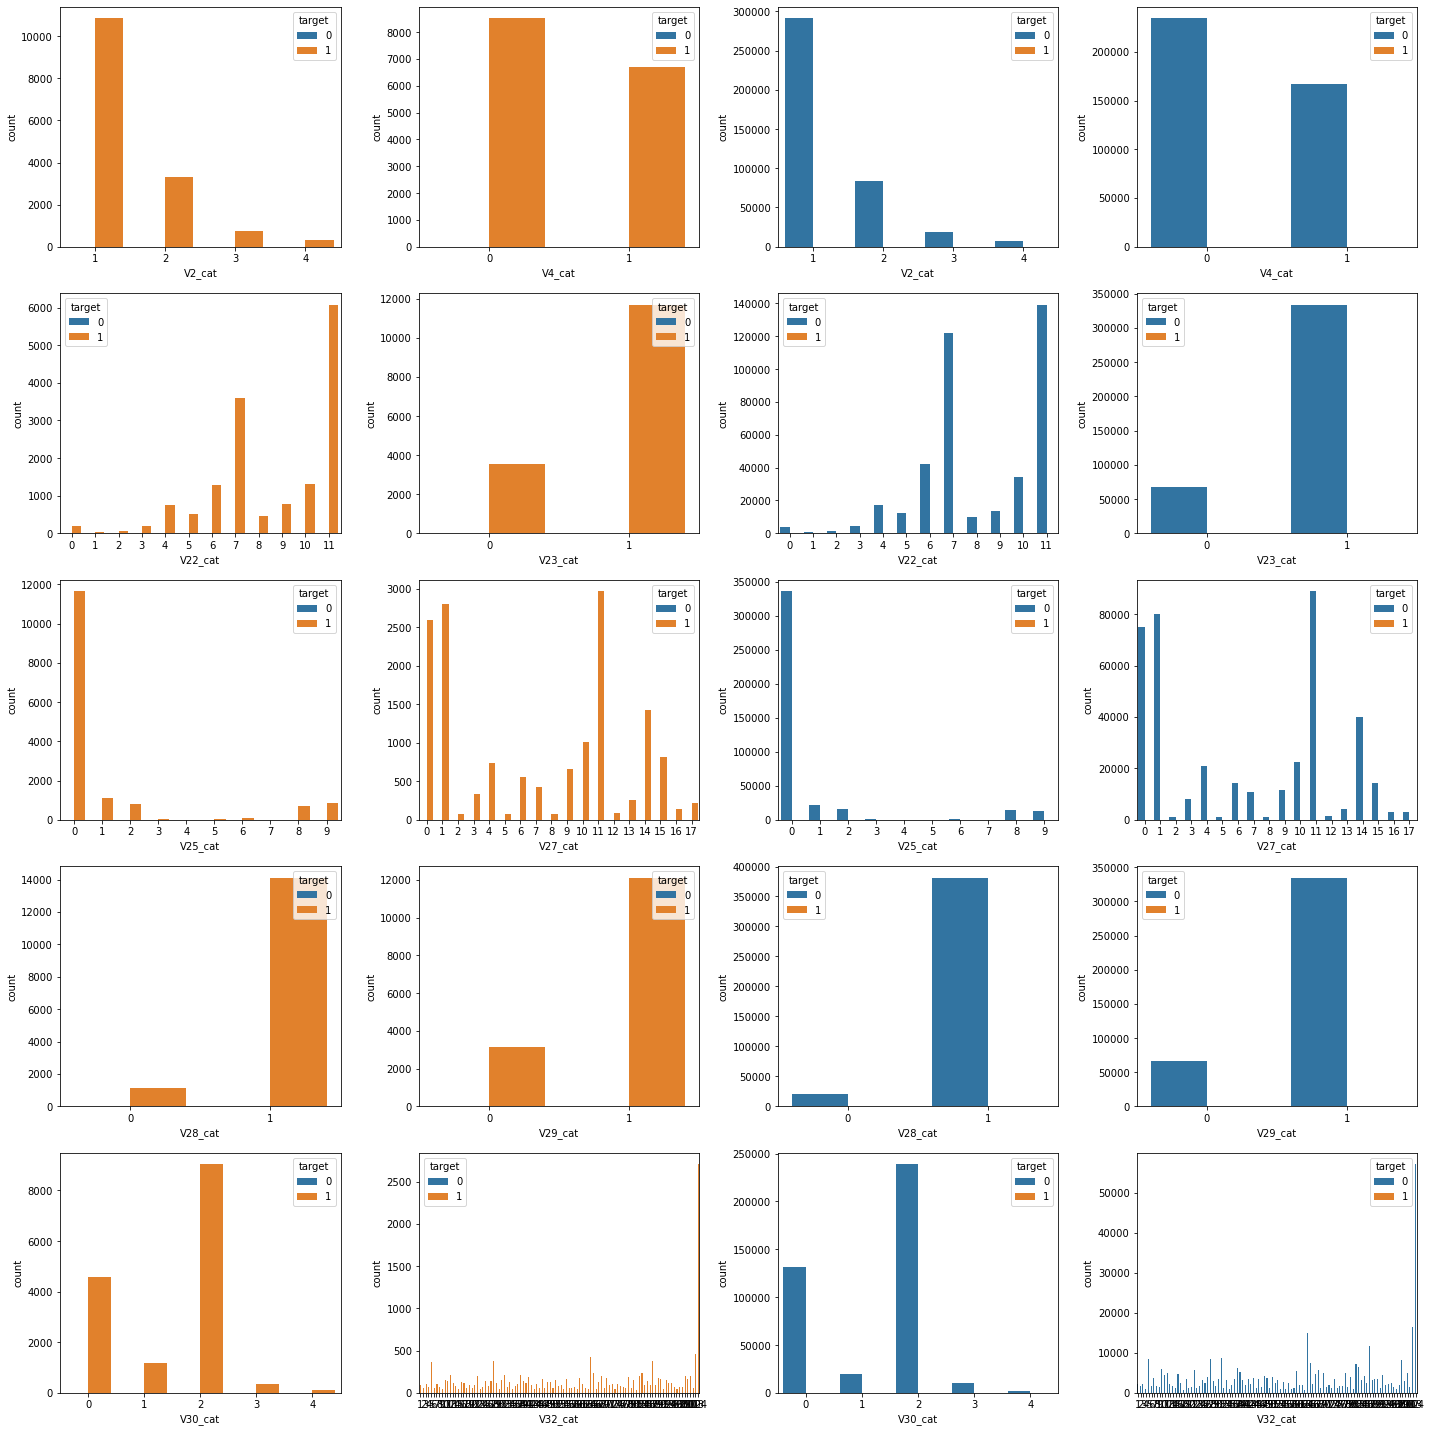

In [12]:
figure, axs = plt.subplots(nrows=(len(col_cath)//2), ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_pos_ii[col_cath]):
    sns.countplot(x=train_pos_ii[col],hue=train_ii['target'],ax=axs[i//2,i%2])
    sns.countplot(x=train_neg_ii[col],hue=train_ii['target'],ax=axs[i//2,i%2+2])
figure.tight_layout() 

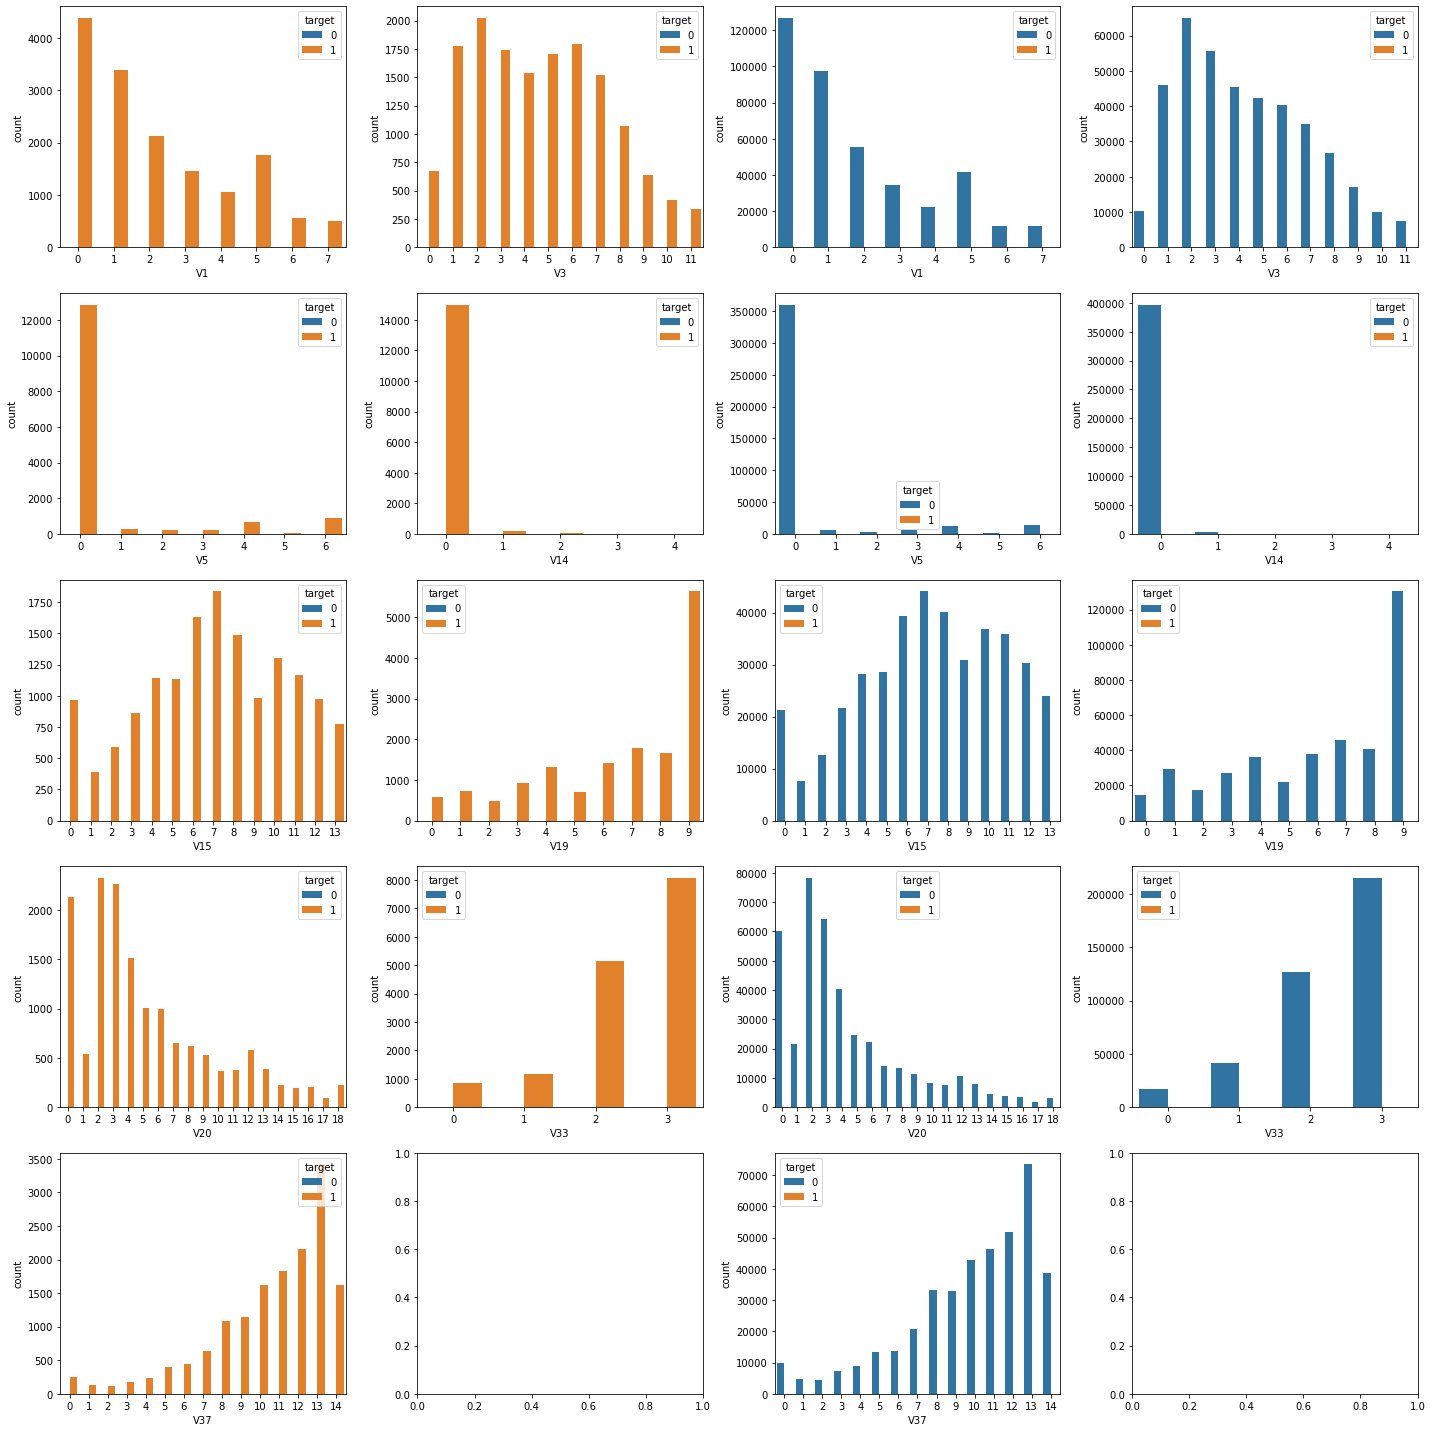

In [13]:
figure, axs = plt.subplots(nrows=(len(col_ordh)//2+1), ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_pos_ii[col_ordh]):
    sns.countplot(x=train_pos_ii[col],hue=train_ii['target'],ax=axs[i//2,i%2])
    sns.countplot(x=train_neg_ii[col],hue=train_ii['target'],ax=axs[i//2,i%2+2])
figure.tight_layout() 

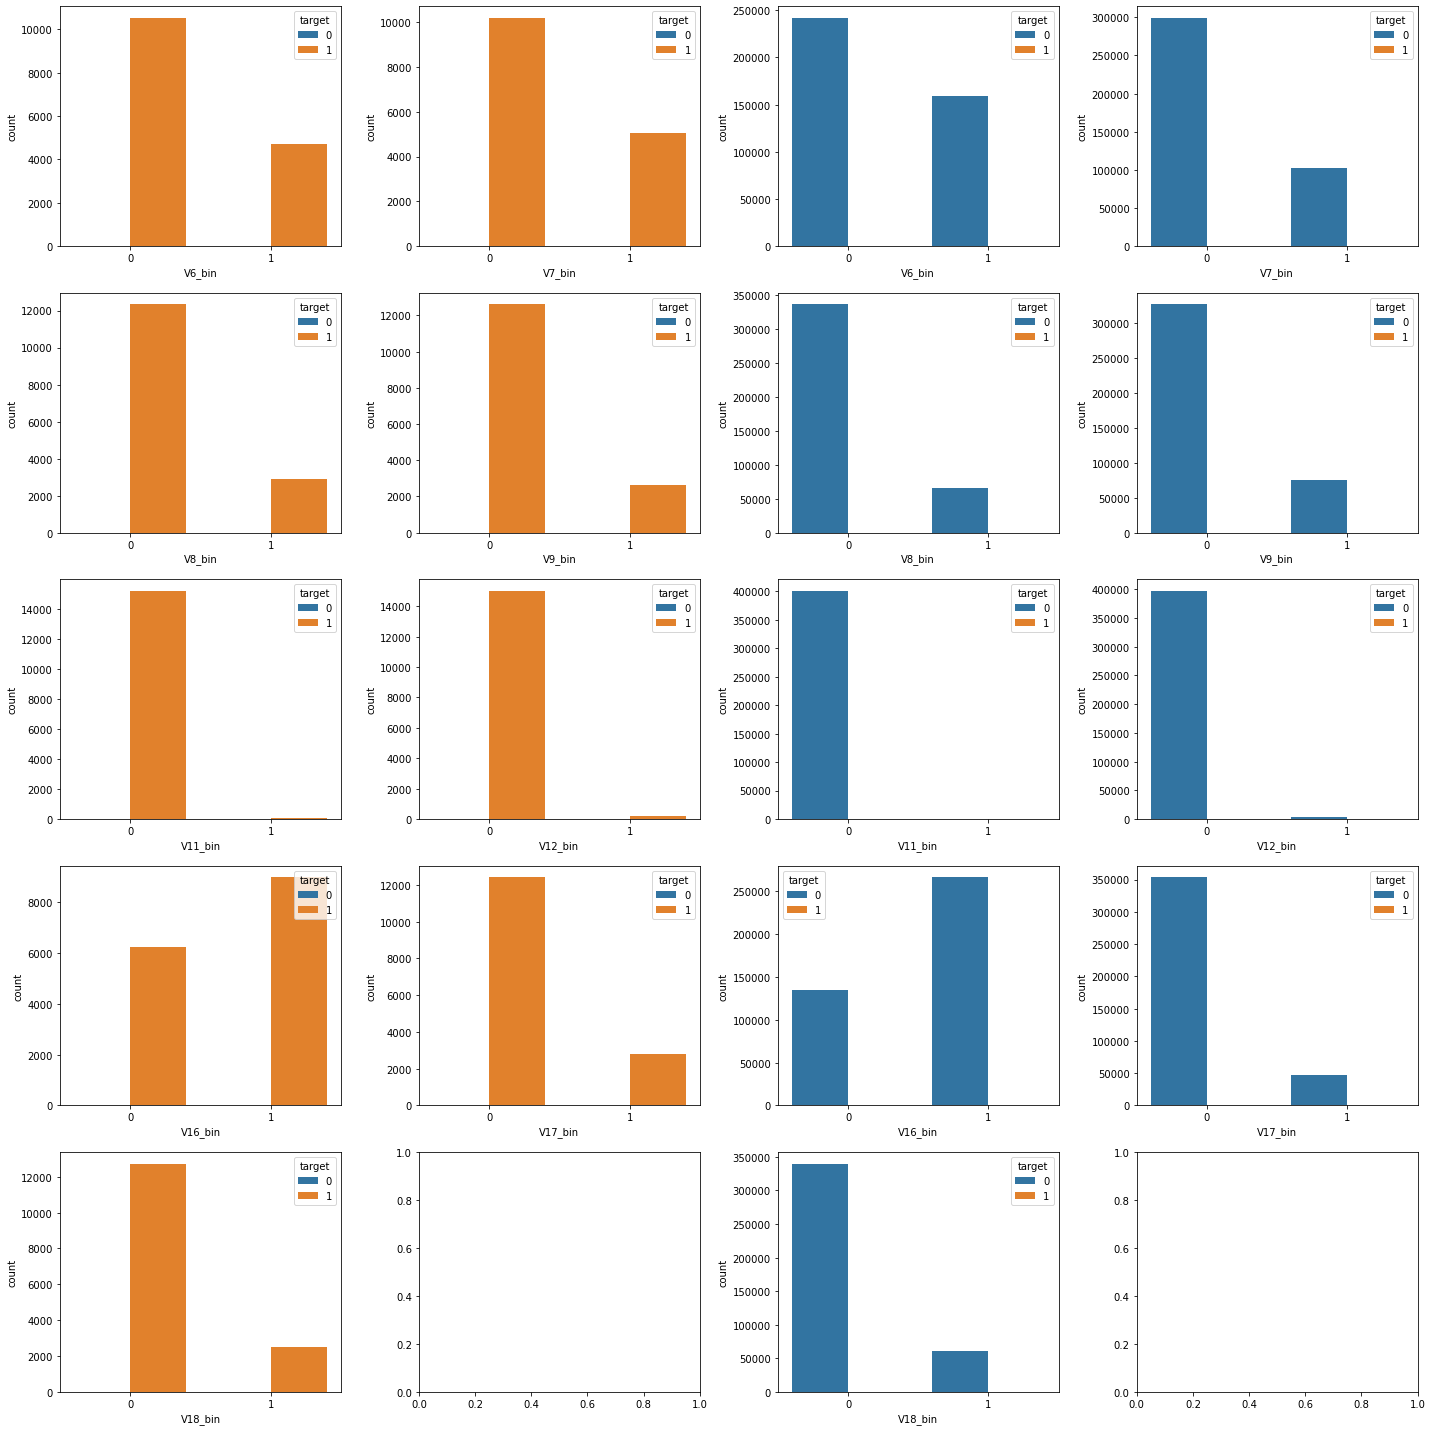

In [14]:
figure, axs = plt.subplots(nrows=(len(col_binh)//2+1), ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_pos_ii[col_binh]):
    sns.countplot(x=train_pos_ii[col],hue=train_ii['target'],ax=axs[i//2,i%2])
    sns.countplot(x=train_neg_ii[col],hue=train_ii['target'],ax=axs[i//2,i%2+2])
figure.tight_layout() 

효과적인 모델결과 평가를 위해서 층화 K-Fold 교차검증을 진행-> Naive Bayes의 특성상 속도가 빠르기 때문에 Fold=10으로 설정

In [121]:
skf = StratifiedKFold(n_splits = 10)

1)보간한 데이터에서 이산형 변수만을 사용하여 Multinomial Naive Bayes 사용

In [122]:
# X_train = train_ii.drop(['target','V21','V34','V35','V36'],axis=1)
# Y_train = train_ii['target']

In [123]:
# X_train

,V2_cat,V4_cat,V22_cat,V23_cat,V25_cat,V27_cat,V28_cat,V29_cat,V30_cat,V32_cat,...,V37,V6_bin,V7_bin,V8_bin,V9_bin,V11_bin,V12_bin,V16_bin,V17_bin,V18_bin
0,1,1,4,1,1,0,1,1,0,75,...,13,0,1,0,0,0,0,0,1,0
1,2,1,10,1,0,10,1,1,2,28,...,9,0,1,0,0,0,0,1,0,0
2,1,0,6,1,0,14,1,1,0,68,...,5,1,0,0,0,0,0,0,0,0
3,1,1,6,1,1,16,1,1,0,104,...,12,0,0,1,0,0,0,1,0,0
4,1,0,7,1,1,3,1,0,2,59,...,13,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416643,1,0,2,1,0,0,1,1,2,32,...,8,0,0,0,1,0,0,1,0,0
416644,2,1,7,1,0,11,1,1,2,19,...,0,1,0,0,0,0,0,0,1,0
416645,1,1,9,1,0,0,1,1,2,46,...,12,0,1,0,0,0,0,0,1,0
416646,1,0,11,0,0,7,1,1,2,104,...,12,1,0,0,0,0,0,1,0,0


In [124]:
# cnt = 1
# f1_s = 0
# for train_idx, valid_idx in skf.split(X_train,Y_train):
#     train_data = train_ii.iloc[train_idx]
#     valid_data = train_ii.iloc[valid_idx]
#     clf = MultinomialNB()
    
#     train_x=train_data.drop(['target','V21','V34','V35','V36'],axis=1)
#     train_y=train_data['target']
#     clf.fit(train_x,train_y)
    
#     valid_x=valid_data.drop(['target','V21','V34','V35','V36'],axis=1)
#     valid_y=valid_data['target']
    
#     pred = clf.predict(valid_x)
    
#     print(cnt," 번째 모델 f1score : " ,f1_score(pred,valid_y,average='macro'))
    
#     f1_s += f1_score(pred,valid_y,average='macro')
#     cnt+=1



# print('모델 f1_score 평균 : ',f1_s/10)

1  번째 모델 f1score :  0.5165479321891404
2  번째 모델 f1score :  0.5181903589971399
3  번째 모델 f1score :  0.5195279426318339
4  번째 모델 f1score :  0.5160930477956068
5  번째 모델 f1score :  0.5093775475126986
6  번째 모델 f1score :  0.5154701250394369
7  번째 모델 f1score :  0.5136378078015924
8  번째 모델 f1score :  0.5193254279170542
9  번째 모델 f1score :  0.5185667900094633
10  번째 모델 f1score :  0.5164232721733041
모델 f1_score 평균 :  0.516316025206727


평균 f1_score를 확인해본 결과 이산형 변수만 사용했음에도 높은 성능을 보이고 있음을 확인

이는 각 변수들 간의 낮은 상관관계로 인한 것으로 예상됨

In [125]:
# clf = MultinomialNB()
# clf.fit(X_train,Y_train)
# target = clf.predict(test_ii.drop(['V21','V34','V35','V36'],axis=1))

In [126]:
# submission=pd.DataFrame({'id':test['id'],'target':target})

In [127]:
# submission

,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
178559,178560,0
178560,178561,0
178561,178562,0
178562,178563,0


In [128]:
# submission.to_csv('C:/Users/wpekt/Desktop/과제/P-SAT/방세/fourth_submission.csv',index=False)

In [129]:
col_cat=[]
col_num=[]
col_bin=[]
col_ord=[]
for i in train_d.columns.to_list()[2:]:
    if '_cat' in i:
        col_cat.append(i)
    elif re.search('_bin',i):
        col_bin.append(i)
    elif train_d[i].nunique()>100:
        col_num.append(i)
    else:
        col_ord.append(i)

In [133]:
train_d[col_bin].isna().sum()

V6_bin     0
V7_bin     0
V8_bin     0
V9_bin     0
V10_bin    0
V11_bin    0
V12_bin    0
V13_bin    0
V16_bin    0
V17_bin    0
V18_bin    0
V52_bin    0
V53_bin    0
V54_bin    0
V55_bin    0
V56_bin    0
V57_bin    0
dtype: int64

In [134]:
train_ii[col_binh].isna().sum()

V6_bin     0
V7_bin     0
V8_bin     0
V9_bin     0
V11_bin    0
V12_bin    0
V16_bin    0
V17_bin    0
V18_bin    0
dtype: int64

2)전처리 과정에서 동질성을 보였던 나머지 이산형 변수 중 결측치가 없는 값들만 추가하여 Multinomial Naive Bayes 사용

In [135]:
# ap_col=['V31_cat','V52_bin','V53_bin','V54_bin','V55_bin','V56_bin','V57_bin','V10_bin','V13_bin']


In [137]:
# train_ap = pd.concat([train_ii,train[ap_col]],axis=1)
# test_ap = pd.concat([test_ii,test[ap_col]],axis=1)

In [138]:
# train_ap

,target,V21,V34,V35,V36,V2_cat,V4_cat,V22_cat,V23_cat,V25_cat,...,V18_bin,V31_cat,V52_bin,V53_bin,V54_bin,V55_bin,V56_bin,V57_bin,V10_bin,V13_bin
0,0,0.999852,0.447214,1.113015,0.444072,1,1,4,1,1,...,0,1,0,0,0,0,0,0,0,0
1,0,1.604875,0.374166,0.852960,0.378814,2,1,10,1,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0.802730,0.399500,0.707676,0.407431,1,0,6,1,0,...,0,1,0,1,1,0,1,0,0,0
3,0,1.002551,0.400000,1.092160,0.373095,1,1,6,1,1,...,0,1,0,1,1,0,1,1,0,0
4,0,0.734422,0.316228,0.805085,0.309677,1,0,7,1,1,...,0,1,0,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416643,0,0.700892,0.316228,0.605126,0.361525,1,0,2,1,0,...,0,1,0,0,1,0,0,0,0,0
416644,0,0.678233,0.315595,0.481067,0.341937,2,1,7,1,0,...,0,1,0,1,1,0,0,0,0,0
416645,0,0.964588,0.400000,0.819456,0.300333,1,1,9,1,0,...,0,1,0,1,1,0,1,0,0,0
416646,0,0.657172,0.400000,1.002744,0.363731,1,0,11,0,0,...,0,1,0,1,0,0,0,0,0,0


In [139]:
# X_train_ap = train_ap.drop(['target','V21','V34','V35','V36'],axis=1)
# Y_train_ap = train_ap['target']

In [142]:
# cnt = 1
# f1_s = 0
# for train_idx, valid_idx in skf.split(X_train_ap,Y_train_ap):
#     train_data = train_ap.iloc[train_idx]
#     valid_data = train_ap.iloc[valid_idx]
#     clf = MultinomialNB()
    
#     train_x=train_data.drop(['target','V21','V34','V35','V36'],axis=1)
#     train_y=train_data['target']
#     clf.fit(train_x,train_y)
    
#     valid_x=valid_data.drop(['target','V21','V34','V35','V36'],axis=1)
#     valid_y=valid_data['target']
    
#     pred = clf.predict(valid_x)
    
#     print(cnt," 번째 모델 f1score : " ,f1_score(pred,valid_y,average='macro'))
    
#     f1_s += f1_score(pred,valid_y,average='macro')
#     cnt+=1



# print('모델 f1_score 평균 : ',f1_s/10)

1  번째 모델 f1score :  0.5159337730891568
2  번째 모델 f1score :  0.5188168644504499
3  번째 모델 f1score :  0.5192336725056074
4  번째 모델 f1score :  0.5158506484142593
5  번째 모델 f1score :  0.5098200798684253
6  번째 모델 f1score :  0.5149198744238276
7  번째 모델 f1score :  0.5139468938178102
8  번째 모델 f1score :  0.5190872466034452
9  번째 모델 f1score :  0.5190285985741426
10  번째 모델 f1score :  0.5171987380474399
모델 f1_score 평균 :  0.5163836389794565


전반적으로 비슷하나 살짝 더 좋은 성능을 보이고 있음을 확인함->변수를 많이 사용하는 것으로 성능을 높일 수 있다는 것을 확인

In [144]:
# clf = MultinomialNB()
# clf.fit(X_train_ap,Y_train_ap)
# target = clf.predict(test_ap.drop(['V21','V34','V35','V36'],axis=1))

In [145]:
# submission=pd.DataFrame({'id':test['id'],'target':target})

In [146]:
# submission

,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
178559,178560,0
178560,178561,0
178561,178562,0
178562,178563,0


In [147]:
# submission.to_csv('C:/Users/wpekt/Desktop/과제/P-SAT/방세/fifth_submission.csv',index=False)

In [148]:
X_train_ap

,V2_cat,V4_cat,V22_cat,V23_cat,V25_cat,V27_cat,V28_cat,V29_cat,V30_cat,V32_cat,...,V18_bin,V31_cat,V52_bin,V53_bin,V54_bin,V55_bin,V56_bin,V57_bin,V10_bin,V13_bin
0,1,1,4,1,1,0,1,1,0,75,...,0,1,0,0,0,0,0,0,0,0
1,2,1,10,1,0,10,1,1,2,28,...,0,1,0,0,0,0,0,0,0,0
2,1,0,6,1,0,14,1,1,0,68,...,0,1,0,1,1,0,1,0,0,0
3,1,1,6,1,1,16,1,1,0,104,...,0,1,0,1,1,0,1,1,0,0
4,1,0,7,1,1,3,1,0,2,59,...,0,1,0,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416643,1,0,2,1,0,0,1,1,2,32,...,0,1,0,0,1,0,0,0,0,0
416644,2,1,7,1,0,11,1,1,2,19,...,0,1,0,1,1,0,0,0,0,0
416645,1,1,9,1,0,0,1,1,2,46,...,0,1,0,1,1,0,1,0,0,0
416646,1,0,11,0,0,7,1,1,2,104,...,0,1,0,1,0,0,0,0,0,0


3)연속형 변수까지 사용한 Mixed Naive Bayes 사용

In [165]:
X_train_ap1 = train_ap.drop(['target'],axis=1)
Y_train_ap1 = train_ap['target']

In [166]:
cat_index=[]
for i in range(4,X_train_ap1.shape[1]):
    cat_index.append(i)


이산형 변수에 Label Encoding을 진행해야 분석을 진행할 수 있어 Label Encoding을 이산형 변수에 적용함

In [167]:
X_train_ap1_arr = np.array(X_train_ap1)
Y_train_ap1_arr = np.array(Y_train_ap1)
label_encoder = LabelEncoder()
for i in cat_index:
    X_train_ap1_arr[:,i] = label_encoder.fit_transform(X_train_ap1_arr[:,i])

In [169]:
X_train_ap_data= pd.DataFrame(X_train_ap1_arr,columns=X_train_ap1.columns)

In [170]:
X_train_ap_data

,V21,V34,V35,V36,V2_cat,V4_cat,V22_cat,V23_cat,V25_cat,V27_cat,...,V18_bin,V31_cat,V52_bin,V53_bin,V54_bin,V55_bin,V56_bin,V57_bin,V10_bin,V13_bin
0,0.999852,0.447214,1.113015,0.444072,0.0,1.0,4.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.604875,0.374166,0.852960,0.378814,1.0,1.0,10.0,1.0,0.0,10.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.802730,0.399500,0.707676,0.407431,0.0,0.0,6.0,1.0,0.0,14.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.002551,0.400000,1.092160,0.373095,0.0,1.0,6.0,1.0,1.0,16.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0.734422,0.316228,0.805085,0.309677,0.0,0.0,7.0,1.0,1.0,3.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416643,0.700892,0.316228,0.605126,0.361525,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
416644,0.678233,0.315595,0.481067,0.341937,1.0,1.0,7.0,1.0,0.0,11.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
416645,0.964588,0.400000,0.819456,0.300333,0.0,1.0,9.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
416646,0.657172,0.400000,1.002744,0.363731,0.0,0.0,11.0,0.0,0.0,7.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [171]:
train_ap_lab=pd.concat([Y_train_ap1,X_train_ap_data],axis=1)

In [172]:
cnt = 1
f1_s = 0
for train_idx, valid_idx in skf.split(X_train_ap_data,Y_train_ap1):
    train_data = train_ap_lab.iloc[train_idx]
    valid_data = train_ap_lab.iloc[valid_idx]
    clf = MixedNB(categorical_features=cat_index)
    
    train_x=train_data.drop(['target'],axis=1)
    train_y=train_data['target']
    clf.fit(train_x,train_y)
    
    valid_x=valid_data.drop(['target'],axis=1)
    valid_y=valid_data['target']
    
    pred = clf.predict(valid_x)
    
    print(cnt," 번째 모델 f1score : " ,f1_score(pred,valid_y,average='macro'))
    
    f1_s += f1_score(pred,valid_y,average='macro')
    cnt+=1



print('모델 f1_score 평균 : ',f1_s/10)

[  4   2  12   2  10  18   2   2   5 104   8  12   7   5  14  10  19   4
  15   2   2   2   2   2   2   2   2   2   3   2   2   2   2   2   2   2
   2]
1  번째 모델 f1score :  0.5186160476155094
[  4   2  12   2  10  18   2   2   5 104   8  12   7   5  14  10  19   4
  15   2   2   2   2   2   2   2   2   2   3   2   2   2   2   2   2   2
   2]
2  번째 모델 f1score :  0.5269356111197356
[  4   2  12   2  10  18   2   2   5 104   8  12   7   5  14  10  19   4
  15   2   2   2   2   2   2   2   2   2   3   2   2   2   2   2   2   2
   2]
3  번째 모델 f1score :  0.520022325867789
[  4   2  12   2  10  18   2   2   5 104   8  12   7   5  14  10  19   4
  15   2   2   2   2   2   2   2   2   2   3   2   2   2   2   2   2   2
   2]
4  번째 모델 f1score :  0.5178443941289118
[  4   2  12   2  10  18   2   2   5 104   8  12   7   5  14  10  19   4
  15   2   2   2   2   2   2   2   2   2   3   2   2   2   2   2   2   2
   2]
5  번째 모델 f1score :  0.518833701133806
[  4   2  12   2  10  18   2   2   5 104   8  1

연속형 변수까지 사용한 Mixed Naive Bayes 사용 결과 매우 뛰어난 성능을 보이는 것을 확인함-> 이를 최종 예측의 모델로 사용하기로 결정

# Predict

예측을 위해 테스트 데이터에도 Label Encoding 진행

In [175]:
test_ap_arr=np.array(test_ap)
label_encoder = LabelEncoder()
for i in cat_index:
    test_ap_arr[:,i] = label_encoder.fit_transform(test_ap_arr[:,i])

In [176]:
test_ap_data= pd.DataFrame(test_ap_arr,columns=test_ap.columns)

Mixed Naive Bayes 모델을 전체 학습데이터로 학습시키고, 이를 바탕으로 예측을 진행함.

In [178]:
clf = MixedNB(categorical_features=cat_index)
clf.fit(X_train_ap_data,Y_train_ap1)
target = clf.predict(test_ap_data)

[  4   2  12   2  10  18   2   2   5 104   8  12   7   5  14  10  19   4
  15   2   2   2   2   2   2   2   2   2   3   2   2   2   2   2   2   2
   2]


In [179]:
submission=pd.DataFrame({'id':test['id'],'target':target})

In [180]:
submission

,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
178559,178560,0
178560,178561,0
178561,178562,0
178562,178563,0


In [181]:
submission.to_csv('C:/Users/wpekt/Desktop/과제/P-SAT/방세/last_submission.csv',index=False)